# Simulating Many Agents

Environments with many agents present a unique challenge for physics simulation: the cost to perform collision detection grows **N^2** with the number of bodies, corresponding to the number of possible pairwise interactions between bodies in the environment.

In order to combat this explosive cost, Brax has culling strategies for quickly selecting a subset of bodies for collision detection.  Brax ships with two strategies:

* **All Pairs**: Brax runs collision detection on every possible pair of bodies during every physics step.  This is the default strategy.
* **Near Neighbors**: Brax fetches the top K closest body pairs to perform collision detection each physics step.

Brax culls a fixed number of candidates each physics steps, according to the `collider_cutoff` parameter in the Brax config.  Because this is a fixed size, collisions may be missed if more exist in a step than `collider_cutoff`.

For now, culling only works on **GPU** - we may introduce a strategy that works on **TPU** in the future.

In [1]:
#@title Install Brax
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

import functools
import time

from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax.io import html

Let's see Brax's performance on a benchmark environment called **Ant Mountain**:

In [2]:
def ant_mountain(count: int, cutoff: int) -> brax.System:
  config = envs.create('ant').sys.config
  repeat = count - 1

  # clone the ant
  for lst in (config.bodies, config.joints, config.actuators):
    for obj in list(lst):
      if obj.name == 'Ground':
        continue
      for i in range(repeat):
        new_obj = lst.add()
        new_obj.CopyFrom(obj)
        for attr in ('name', 'joint', 'parent', 'child'):
          if hasattr(new_obj, attr):
            setattr(new_obj, attr, f'{getattr(new_obj, attr)}_{i}')

  # sprinkle ants in a delicate spiral
  default = config.defaults.add()
  for i in range(repeat):  
    qp = default.qps.add(name=f'$ Torso_{i}')
    qp.pos.x = jnp.sin(i * jnp.pi / 2)
    qp.pos.y = jnp.cos(i * jnp.pi / 2)
    qp.pos.z = (i + 1) * 2

  # turn on all collisions:
  del config.collide_include[:]

  config.collider_cutoff = cutoff
  return brax.System(config)

Setting cutoff > 0 enables the **Near Neighbors** culling strategy.  Setting an approrpiate cutoff depends on the dynamics of the scene and the tolerance for error.  Small cutoffs allow collisions to slip through - try it out for yourself:

In [3]:
#@title Visualize Ant Mountain

num_ants = 20 #@param {type:"slider", min:1, max:25, step:1}
cutoff = 0 #@param {type:"slider", min:0, max:5000, step:1}
sys = ant_mountain(num_ants, cutoff)
qps = [sys.default_qp()]
act = jnp.array([0] * 8 * (num_ants))

for _ in range(100):
  qp, _ = sys.step(qps[-1], act)
  qps.append(qp)

HTML(html.render(sys, qps))

Here we see the impact of using **Near Neighbors** culling on environment performance as we increase the number of bodies in the environment.  Culling introduces dramatic improvements to performance:

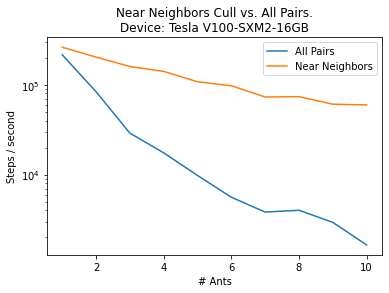

In [ ]:
def testSpeed(num_ants: int, cutoff: int) -> float:
  batch_size = 1024
  sys = ant_mountain(num_ants, cutoff)
  num_devices = len(jax.devices())
  num_per_device = batch_size // num_devices
  act = jnp.array([[0] * 8 * (num_ants)] * num_per_device)
  qp = sys.default_qp()
  qp = jax.tree_map(lambda *args: jnp.stack(args), *[qp] * num_per_device)
  qp = jax.tree_map(lambda *args: jnp.stack(args), *[qp] * num_devices)

  @functools.partial(jax.pmap, axis_name='i')
  def run_sys(qp):
    qp, _ = jax.vmap(sys.step)(qp, act)
    return qp

  sps = []
  for seed in range(6):
    jax.device_put(qp)
    t = time.time()
    run_sys(qp).pos.block_until_ready()
    sps.append(batch_size / (time.time() - t))

  mean_sps = jnp.mean(jnp.array(sps[1:]))
  return mean_sps

allpairs_sps = []
cutoff_sps = []

for i in range(1, 11):
  allpairs_sps.append(testSpeed(i, 0))
  cutoff_sps.append(testSpeed(i, i * 9))

plt.plot(range(1, len(allpairs_sps) + 1), allpairs_sps, label = "All Pairs")
plt.plot(range(1, len(cutoff_sps) + 1), cutoff_sps, label = "Near Neighbors")
plt.legend()
plt.xlabel('# Ants')
plt.ylabel('Steps / second')
plt.yscale('log')
plt.title(f'Near Neighbors Cull vs. All Pairs.\nDevice: {jax.devices()[0].device_kind}')
plt.show()